# Quickstart
First let import the modules to work with

In [1]:
from rdkit import Chem
from moldrug import utils, fitness
from moldrug.data import receptors, ligands, boxes
import tempfile, os, gzip, shutil, requests
from multiprocessing import cpu_count

We will use the some test examples on the `moldrug.data` module.

In [3]:
# Creating a temporal directory
tmp_path = tempfile.TemporaryDirectory()
# Creating receptors files
r_x0161_file = os.path.join(tmp_path.name, 'r_x0161.pdbqt')
with open(r_x0161_file, 'w') as r:
    r.write(receptors.r_x0161)

Now let's download the crem data base. Here we are downloading the smaller one. But consider to visit [CReM](https://github.com/DrrDom/crem) for more information about how to use and create the data base of fragments.

In [4]:
url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = os.path.join(tmp_path.name,'crem.db.gz')
crem_db_path = os.path.join(tmp_path.name,'crem.db')
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Now We initialize the `GA` class. 

In [5]:
maxiter = 3
popsize = 20
njobs = 2

out = utils.GA(
    seed_smiles=ligands.r_x0161,
    maxiter=maxiter,
    popsize=popsize,
    crem_db_path = crem_db_path,#'/home/ale/GITLAB/bi_crem_database/replacements02_sc2.db',
    pc = 1,
    get_similar = False,
    mutate_crem_kwargs = {
        'radius':3,
        'min_size':1,
        'max_size':8,
        'min_inc':-5,
        'max_inc':3,
        'ncores':cpu_count(),
    },
    costfunc = fitness.Cost,#__CostSimilarity,# __VinaCostLipinski, Cost, __VinaCost, __QedSasVinaCost, CostMultiReceptors
    costfunc_kwargs = {
        'vina_executable': 'vina',
        'receptor_path': r_x0161_file,
        'boxcenter' : boxes.r_x0161["A"]['boxcenter'] ,
        'boxsize': boxes.r_x0161["A"]['boxsize'],
        'exhaustiveness': 4,
        'ncores': int(cpu_count() / njobs),
        'num_modes': 1,
    },
    save_pop_every_gen = 20,
    deffnm = os.path.join(tmp_path.name, 'pop_test_single_receptor')
)


Then we call the class

In [6]:
out(njobs = njobs)



Creating the first population with 20 members:


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]

Initial Population: Best individual: Individual(idx = 5, smiles = NS(=O)(=O)c1ccc(C2(O)CCNCC2)cc1, cost = 0.6076297216634597)
File /tmp/tmpna40vpr7/pop_test_single_receptor_pop.sdf was createad!


Evaluating generation 1 / 3:


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]

Generation 1: Best Individual: Individual(idx = 22, smiles = NS(=O)(=O)c1ccc(COc2cccc(O)c2)cc1, cost = 0.5945198669617732).



Evaluating generation 2 / 3:


 15%|█▌        | 3/20 [00:08<00:43,  2.56s/it]

This is a very silly example. In real life, you should increase the population size and the number of generation. In this way we explore in a better way ther chemical space. The `GA` clas has some nice methods that give you an idea of the obtained results.

In [ ]:
out.to_dataframe().tail()

,smiles,idx,pdbqt,cost,qed,sa_score,vina_score
74,COC(=O)c1ccc(NC(=S)NCC(C)O)cc1,74,MODEL 1\nREMARK VINA RESULT: -5.8 0....,1.000000,0.561765,2.315570,-5.8
75,CC(Sc1ccc(OCCN2CCCC2)cc1)C(N)=O,75,MODEL 1\nREMARK VINA RESULT: -5.8 0....,1.000000,0.782761,2.418557,-5.8
76,CCSC(=S)SCc1ccc(C(=O)OC)cc1,76,MODEL 1\nREMARK VINA RESULT: -4.8 0....,1.000000,0.620342,2.424015,-4.8
77,C#CCN(N)c1ccc(C(F)(F)F)cc1,77,MODEL 1\nREMARK VINA RESULT: -5.4 0....,1.000000,0.463317,2.719737,-5.4
78,CC(=O)NNC(=O)c1ccc(CC(CC(=O)O)C(=O)O)cc1,78,MODEL 1\nREMARK VINA RESULT: -6.8 0....,0.546637,0.554267,2.482462,-6.8


You could save the entire class for future use both in a compressed file. Here I just saved the file in the temporal directory, you could change the path to your current working directory.

In [ ]:
out.pickle(os.path.join(tmp_path.name, f"NumGens_{out.NumGens}_PopSize_{popsize}"), compress=True)

But Could be that after a long simulation we would like to perform a different searching strategy over the last population. This is really simple, we could initialize againg the `out` instance with a differnt set of parameters. Let say that we would like close to the last solutions. Then we could use the parameters: `min_size=0, max_size=1, min_inc=-1, max_inc=1`.This flavor will add, delate mutate heavy atoms or change Hydrogens for heavy atoms.

In [ ]:
out.maxiter = 5
out.mutate_crem_kwargs = {
        'radius':3,
        'min_size':0,
        'max_size':1,
        'min_inc':-1,
        'max_inc':1,
        'ncores':cpu_count(),
    }

And run againg the class

In [ ]:
out(njobs = njobs)

Evaluating generation 4 / 8:


100%|██████████| 20/20 [00:28<00:00,  1.40s/it]

Generation 4: Best Individual: Individual(idx = 88, smiles = NS(=O)(=O)c1ccc(NNC(=O)c2ccncc2)cc1, cost = 0.5457306975450334).



Evaluating generation 5 / 8:


100%|██████████| 19/19 [00:32<00:00,  1.69s/it]

Generation 5: Best Individual: Individual(idx = 88, smiles = NS(=O)(=O)c1ccc(NNC(=O)c2ccncc2)cc1, cost = 0.5457306975450334).



Evaluating generation 6 / 8:


100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

Generation 6: Best Individual: Individual(idx = 133, smiles = CN(NC(=O)c1ccncc1)c1ccc(S(N)(=O)=O)cc1, cost = 0.44967879185089554).



Evaluating generation 7 / 8:


100%|██████████| 18/18 [00:31<00:00,  1.73s/it]

Generation 7: Best Individual: Individual(idx = 133, smiles = CN(NC(=O)c1ccncc1)c1ccc(S(N)(=O)=O)cc1, cost = 0.44967879185089554).



Evaluating generation 8 / 8:


100%|██████████| 19/19 [00:34<00:00,  1.80s/it]

Generation 8: Best Individual: Individual(idx = 133, smiles = CN(NC(=O)c1ccncc1)c1ccc(S(N)(=O)=O)cc1, cost = 0.44967879185089554).


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 5 generations with a population of 20 individuals. A total number of 174 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = COC(=O)C=1C=CC(=CC1)S(=O)(=O)N, cost = 1.0)
Final Individual: Individual(idx = 133, smiles = CN(NC(=O)c1ccncc1)c1ccc(S(N)(=O)=O)cc1, cost = 0.44967879185089554)
The cost fucntion droped in 0.5503212081491045 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

'__call__'  193031.96 ms


As you can see the `GA` class is updated reather that replacead. This is a perfect feature for rerun with different ideas. As you see the number of generations is also updatead as well the number of calls.

In [ ]:
print(out.NumGens, out.NumCalls)

8 2


The same idea is for the rest of the methods and atributtes

In [ ]:
out.to_dataframe().tail()

,smiles,idx,pdbqt,cost,qed,sa_score,vina_score
169,NS(=O)(=O)c1ccc(NNC(=O)c2ccnc(Cl)c2)cc1,169,MODEL 1\nREMARK VINA RESULT: -6.6 0....,0.581768,0.575517,2.113010,-6.6
170,C=CS(=O)(=O)c1ccc(N(C)Cc2cc(F)cc(Br)c2)cc1,170,MODEL 1\nREMARK VINA RESULT: -6.6 0....,0.535841,0.777729,2.460395,-6.6
171,COc1ccc(Cl)cc1C=[N+]([O-])c1ccc(S(=O)(=O)O)cc1,171,MODEL 1\nREMARK VINA RESULT: -6.4 0....,0.724682,0.303473,2.432525,-6.4
172,NNS(=O)(=O)c1ccc(OC(=O)c2cc(N)nc(F)c2)cc1,172,MODEL 1\nREMARK VINA RESULT: -7.4 0....,0.631541,0.239349,2.499351,-7.4
173,CNC(=O)C=Cc1ccc(OCc2cccc(O)c2)cc1C,173,MODEL 1\nREMARK VINA RESULT: -6.6 0....,0.535841,0.833992,2.166602,-6.6


This is the best solution of this simulation (you for sure, will get a different one):

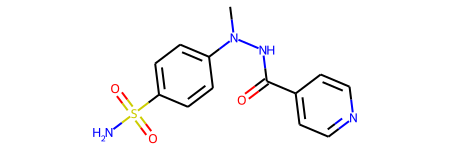

In [ ]:
Chem.MolFromSmiles(out.pop[0].smiles)

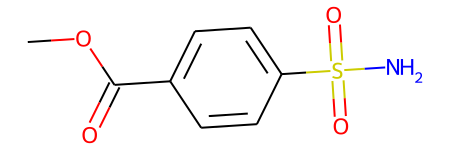

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles("COC(=O)C=1C=CC(=CC1)S(=O)(=O)N")

Printing some information

Initial vina score: -5.1. Final vina score: -7.0
sascorer of the best Individual: 2.2216932225541868
QED of the best Individual: 0.8006849419310699
{
  "NumHAcceptors": 5,
  "NumHDonors": 2,
  "wt": 306.3470000000001,
  "MLogP": 0.5102000000000001,
  "NumRotatableBonds": 4,
  "TPSA": 105.39,
  "FractionCSP3": 0.07692307692307693,
  "HeavyAtomCount": 21,
  "NHOHCount": 3,
  "NOCount": 7,
  "NumAliphaticCarbocycles": 0,
  "NumAliphaticHeterocycles": 0,
  "NumAliphaticRings": 0,
  "NumAromaticCarbocycles": 1,
  "NumAromaticHeterocycles": 1,
  "NumAromaticRings": 2,
  "NumHeteroatoms": 8,
  "NumSaturatedCarbocycles": 0,
  "NumSaturatedHeterocycles": 0,
  "NumSaturatedRings": 0,
  "RingCount": 2
}


[Text(0.5, 1.0, 'bestcost')]

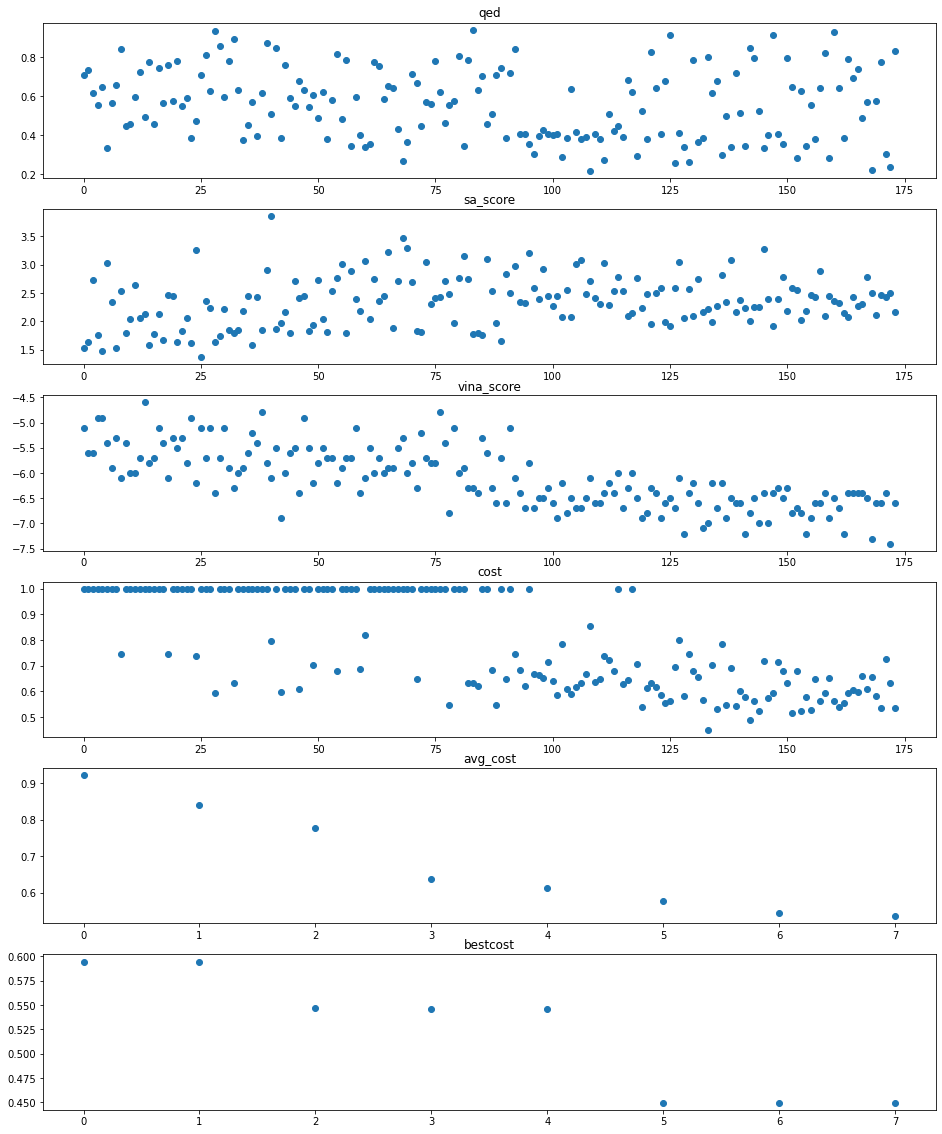

In [ ]:
import json
import matplotlib.pyplot as plt
from moldrug import utils
sascorer = utils.import_sascorer()
print(f"Initial vina score: {out.InitIndividual.vina_score}. Final vina score: {out.pop[0].vina_score}")
print(f"sascorer of the best Individual: {sascorer.calculateScore(out.pop[0].mol)}")
print(f"QED of the best Individual: {fitness.QED.weights_mean(out.pop[0].mol)}")
print(json.dumps(utils.lipinski_profile(out.pop[0].mol), indent = 2))

fig, ax = plt.subplots(nrows = 6, figsize = (16,20))

ax[0].plot(range(len(out.SawIndividuals)),[Individual.qed for Individual in out.SawIndividuals], 'o')
ax[0].set(title = 'qed')

ax[1].plot(range(len(out.SawIndividuals)),[Individual.sa_score for Individual in out.SawIndividuals], 'o')
ax[1].set(title = 'sa_score')

ax[2].plot(range(len(out.SawIndividuals)),[Individual.vina_score for Individual in out.SawIndividuals], 'o')
ax[2].set(title = 'vina_score')

ax[3].plot(range(len(out.SawIndividuals)),[Individual.cost for Individual in out.SawIndividuals], 'o')
ax[3].set(title = 'cost')

ax[4].plot(range(len(out.avg_cost)),out.avg_cost, 'o')
ax[4].set(title = 'avg_cost')

ax[5].plot(range(len(out.bestcost)),out.bestcost, 'o')
ax[5].set(title = 'bestcost')
